In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
import scipy.stats as st
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [3]:
train = pd.read_csv('/content/drive/MyDrive/MLP Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLP Project/test.csv')
train = train[train.columns[1:]]
test = test[test.columns[1:]]
cols = test.columns

In [4]:
d = {'v_1': 'Binary',
'v_26': 'Binary',
'v_11': 'Binary',
'v_14': 'Binary',
'v_30': 'Binary', 'v_28': 'Binary', 'v_9': 'Binary', 'v_27': 'Binary',
'v_32': 'Nominal', 'v_4': 'Nominal',
'v_3': 'Nominal',
'v_20': 'Nominal',
'v_21': 'Nominal',
'v_18': 'Nominal',
'v_25': 'Nominal',
'v_12': 'Nominal', 'v_31': 'Ordinal',
'v_15': 'Ordinal',
'v_19': 'Ordinal',
'v_13': 'Ordinal',
'v_33': 'Ordinal',
'v_17': 'Ordinal',
'v_29': 'Ordinal',
'v_23': 'Ordinal',
'v_6': 'Ordinal', 'v_24': 'Ordinal', 'v_10': 'Ordinal', 'v_5': 'Ordinal',
'v_22': 'Ordinal', 'v_0': 'Ordinal',
'v_16': 'Ratio',
'v_2': 'Ratio',
'v_8': 'Ratio',
'v_7': 'Ratio' ,'v_34': 'Ratio', 'v_35': 'Ratio' ,'v_36': 'Ratio' ,'v_37': 'Ratio' ,'v_38': 'Ratio' ,'v_39': 'Ratio' ,'v_40': 'Ratio'}
types = list(set([value for key,value in d.items()]))
d = {k:[key for key,values in d.items() if values==k] for k in types}
numerical = d['Ratio']
nominal = d['Nominal']
ordinal = d['Ordinal']
binary = d['Binary']

In [5]:
X,Y = train.iloc[:,:-1], train.iloc[:,-1]

In [6]:
X,Y = SMOTE(sampling_strategy='not majority',random_state=42).fit_resample(X,Y)
len(Y[Y==0]), len(Y[Y==1]), len(Y[Y==2])

(1863, 1863, 1863)

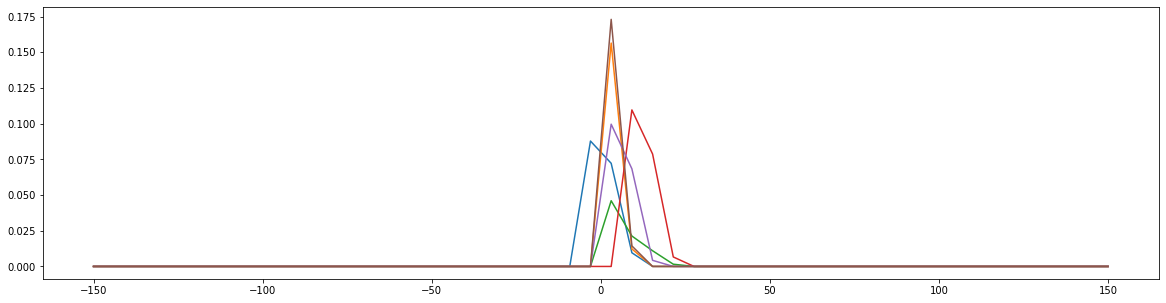

In [7]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
normal = []
for i in range(len(numerical)):
  x = X[numerical[i]]
  eval_points = np.linspace(-150, 150)
  kernel = st.gaussian_kde(x)
  y = kernel.pdf(eval_points)
  if np.max(y) < 0.04:
    continue
  normal.append(numerical[i])
  plt.plot(eval_points, y)
minmax = list(set(numerical) - set(normal)) 

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)

In [9]:
ct = ColumnTransformer([("normal", StandardScaler(), normal),
                        ("minmax", MinMaxScaler(), minmax),
                        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal+nominal),
                        ("binary", 'passthrough', binary)])
le = LabelEncoder()
X_train_transformed = ct.fit_transform(X_train)
Y_train_transformed = le.fit_transform(Y_train)
X_test_transformed = ct.transform(X_test)
Y_test_transformed = le.transform(Y_test)

In [67]:
def Testing(estimator, X_train, Y_train, X_test, Y_test):
  est = estimator.fit(X_train, Y_train)
  Y_pred = est.predict(X_test)
  score = f1_score(Y_test_transformed,est.predict(X_test_transformed), average='weighted')
  print(classification_report(Y_test_transformed,est.predict(X_test_transformed)))
  print(score)
  return score

In [11]:
def Validation(estimator, X, Y):
  v = []
  skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  for train, test in skf.split(X,Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    Y_train, Y_test = Y.iloc[train], Y.iloc[test]
    X_train_transformed = ct.fit_transform(X_train)
    Y_train_transformed = le.fit_transform(Y_train)
    X_test_transformed = ct.transform(X_test)
    Y_test_transformed = le.transform(Y_test)
    estimator.fit(X_train_transformed, Y_train_transformed)
    v.append(f1_score(Y_test_transformed, estimator.predict(X_test_transformed),average='weighted'))
  return np.mean(np.asarray(v))

In [78]:
gcb = GradientBoostingClassifier(min_samples_leaf=30, min_samples_split=50,
                           n_estimators=4800, n_iter_no_change=10,
                           random_state=42)
svc = SVC(kernel='rbf', C=500, random_state=42, probability=True, decision_function_shape='ovr')
abc = abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=12, min_samples_split=8),
                         random_state=42, n_estimators=1000, learning_rate=0.5)
rfc = RandomForestClassifier(n_estimators=1501, random_state=42)
sgd = SGDClassifier(loss='squared_hinge', random_state=42, penalty='elasticnet',
                    l1_ratio=0.5, learning_rate='optimal', eta0=10, 
                    early_stopping=True, validation_fraction=0.1, n_iter_no_change=9)
xgbc = xgb.XGBClassifier(learning_rate=0.7894736842105263, max_depth=12, n_estimators=7447,
              objective='multi:softprob', random_state=42, reg_alpha=12,
              reg_lambda=45)
mlpc = MLPClassifier(hidden_layer_sizes=(1024,512,256,128),activation='logistic', 
                     learning_rate='adaptive', random_state=42, 
                     max_iter=500, early_stopping=True, 
                     validation_fraction=0.1, n_iter_no_change=10, tol=1e-6)

In [70]:
vch = VotingClassifier([('gcb', gcb),
                       ('svc', svc),
                       ('abc', abc),
                       ('rfc', rfc),
                       ('xgbc', xgbc),
                       ('mlpc', mlpc)], voting='hard')

In [71]:
vch.fit(X_train_transformed, Y_train_transformed)

VotingClassifier(estimators=[('gcb',
                              GradientBoostingClassifier(min_samples_leaf=30,
                                                         min_samples_split=400,
                                                         n_estimators=1000,
                                                         n_iter_no_change=10,
                                                         random_state=42)),
                             ('svc',
                              SVC(C=500, probability=True, random_state=42)),
                             ('abc',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=12,
                                                                                       min_samples_split=8,
                                                                                       random_state=42),
                                                 learning_rate=0.5,
                                         

In [73]:
print(classification_report(Y_test_transformed,vch.predict(X_test_transformed)))
print(f1_score(Y_test_transformed,vch.predict(X_test_transformed), average='weighted'))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       372
           1       0.80      0.87      0.83       373
           2       0.81      0.75      0.78       373

    accuracy                           0.81      1118
   macro avg       0.81      0.81      0.81      1118
weighted avg       0.81      0.81      0.81      1118

0.8096598460291486


In [79]:
vcs = VotingClassifier([('gcb', gcb),
                       ('svc', svc),
                       ('abc', abc),
                       ('rfc', rfc),
                       ('xgbc', xgbc)], voting='soft')

In [80]:
Testing(vcs, X_train_transformed, Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       372
           1       0.79      0.88      0.83       373
           2       0.83      0.79      0.81       373

    accuracy                           0.82      1118
   macro avg       0.83      0.82      0.82      1118
weighted avg       0.83      0.82      0.82      1118

0.8226091967256278


0.8226091967256278

In [81]:
Validation(vch,X,Y)

0.8141416319669219

In [82]:
Validation(vcs,X,Y)

0.8249650345074688

In [65]:
Y_pred = vcs.predict(ct.transform(test))

In [66]:
pd.Series(Y_pred).to_csv('/content/drive/MyDrive/MLP Project/submission.csv')